In [86]:
# Workaround to use src modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [87]:
# Library imports
import imageio
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters
from skimage.color import rgb2lab
from scipy.stats import mode

# Functions Imports
from src.utils import image_to_grayscale, image_minmax_norm
from src.quantization import image_bitshift
from src.segmentation import threshold_segmentation, otsu_segmentation
from src.visualizations import visualize_bitshift_images

#flood
from skimage.morphology import flood

#flood fill
from skimage.morphology import flood_fill

## Objetivo

Continuando o pipeline de recolorização da imagem com N cores, esse notebook explora a possibilidade de remover segmentos muito pequenos (portanto não coloríveis) utilizando a técnica de floodfill para computar o tamanho de cada região e recolorindo com cores vizinhas.

**Resultado** infelizmente a técnica é muito lenta e extremamente inviável de ser inserida no pipeline final, mas ainda assim interessante de ser considerada

In [88]:
from sklearn.cluster import KMeans
from scipy.ndimage import convolve
from scipy.ndimage import gaussian_filter

def palette_kmeans(image, N):
    # Pré-proccess: precisamos mudar a imagem de (N,N,3) p/ (N²,3)
    image_inline =  image.reshape(-1,3)
    
    # Training the model
    kmeans = KMeans(n_clusters=N, max_iter=300)
    kmeans.fit(image_inline)
    
    # Return Collor pallete (np.array)
    palette = kmeans.cluster_centers_
    
    # Reconstruct the image with the N colors
    image_labels = kmeans.predict(image_inline)
    image_labels = image_labels.reshape((image.shape[0], image.shape[1]))
    image_output = np.zeros(image.shape)
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_output[i,j,:] = palette[image_labels[i,j]]
    
    return palette, image_output, image_labels, kmeans

def labels_to_edges(labels):
    # Pre-proccess: add symetric pad to avoid corners bugs
    edge_map = np.zeros(labels.shape, dtype=int)
    labels   = np.pad(labels, 1, mode="symmetric")
    
    # Apply Laplacian filter to detect if any 8-neighboor is diff
    # not edge -> 0 (black)
    # edge     -> 1 (white)
    for i in range(1,labels.shape[0]-1):
        for j in range(1,labels.shape[1]-1):
            same_color = np.sum(labels[i-1:i+2,j-1:j+2] == labels[i,j]) != 9
            # print(i,j,same_color)
            # print(labels[i-1:i+2,j-1:j+2])
            edge_map[i-1, j-1] = same_color * 1
    
    return edge_map

In [89]:
def plot_pallete(palette, shape):
    plt.figure(figsize=(12,1))
    for i in range(palette.shape[0]):
        plt.subplot(shape[0],shape[1],i+1)
        plt.axis("off")
        plt.imshow(np.ones((3,3,3), dtype=int)*palette[i].astype(int))
        
def plot_imagegrid(images, shape, figsize=(40,40)):
    plt.figure(figsize=figsize)
    for i in range(len(images)):
        plt.subplot(shape[0],shape[1],i+1)
        plt.imshow(images[i].astype(int), cmap="gray")

In [90]:
def kill_the_bitch(aux, vet, i):
    x = vet[i][0]
    y = vet[i][1]
    
    new_color = 100
    # esquerda -> diminuindo o y
    while (new_color == 100 and y != 0):
        if aux[x][y-1] != i:
            #achou cor nova!!!
            new_color = aux[x][y-1]
        else:
            y -= 1
            
    # direita -> aumentando o y
    while (new_color == 100 and y < aux.shape[1]):
        if aux[x][y+1] != i:
            #achou cor nova!!!
            new_color = aux[x][y+1]
            #TODO: verificar se a nova cor tbm deve ser eliminada
        else:
            y += 1
    
    #atualizar matriz
    aux[aux == i] = new_color
    
    #atualizar area
    vet[new_color*(-1) - 1][2] += vet[i][2]
    vet[i][2] = 0
    
    return aux, vet
    

In [91]:
#flood
#flood(image, seed_point)
#image: An n-dimensional array.
#seed_point: The point in image used as the starting point for the flood fill.
#return:
#mask: A Boolean array with the same shape as image is returned
#with True values for areas connected to and equal (or within tolerance of) the seed point
#All other values are False.
    
#flood fill
#flood_fill(image, seed_point, new_value)
#image: An n-dimensional array
#seed_point: The point in image used as the starting point for the flood fill
#new_value: New value to set the entire fill
#Return: An array with the same shape as image is returned
#with values in areas connected to and equal (or within tolerance of) the seed point replaced with new_value


def image_flood_fill(image):
    aux = image
    
    # matriz auxiliar das dimensoes da imagem
    #aux = image.astype(np.int32)
    print(type(aux))
    print(type(aux[0]))
    print(type(aux[0][0]))

    vet = []
    # oq tem no vet?
    # (x, y) - inicio da regiao
    # area
    
    label = -1
    x = 0
    y = 0
    count = 0
    # encontra posição para chamar o flood fill
    for x in range(aux.shape[0]):
        for y in range(aux.shape[1]):
            if aux[x][y] >= 0:
                aux = flood_fill(aux, (x, y), label)
                count += 1
                #contar quantos tem na regiao
                area = np.sum(aux == label)
                print(area)
                #armazena informações sobre a regiao em vet
                list_info = [x, y, area]
                vet.append(list_info)

                #incrementa o label da regiao
                label -= 1
    print (aux)

    #apagar regiões
    threshold = 20
    
    for i in range(len(vet)):
        if vet[i][2] < threshold:
            aux, vet = kill_the_bitch(aux, vet, i)
                    
    #atualizar aux
    for i in range(len(vet)):
        if vet[i][2] != 0:
            aux[aux == i*(-1)-1] = image[vet[i][0], vet[i][1]]
        
    return aux.astype(np.uint8)

In [92]:
def exploratory_pipeline(image_path, N=8, palette_shape=(2,8), save_path=None):
    
    # Obs: Em imagens png ignorar o alpha usando image[:,:,:3]
    image = imageio.imread(image_path).astype(np.uint8)
    
    # Pipeline 1 - No Image Pre-proccess 
    # - Quantization to pallete with N  colors
    # - Edge detection based on image labes
    palette, image_kmean, labels, model = palette_kmeans(image[:,:,:3], N) # Obs: pode levar até 1 min :P
    return labels
#     edges = labels_to_edges(labels)
    
#     plot_pallete(palette, palette_shape)
#     plot_imagegrid([image, image_kmean, edges], shape=(1,3), figsize=(40,40))
    
#     # Pipeline 2 - Image enhance before quantize
#     image_smooth = np.zeros(image[:,:,:3].shape)
#     for c in range(3):
#         image_smooth[:,:,c] = gaussian_filter(image[:,:,c], sigma=2, mode='nearest')
#     palette, image_kmean, labels, model = palette_kmeans(image_smooth[:,:,:3], N) # Obs: pode levar até 1 min :P
#     edges = labels_to_edges(labels)
    
#     plot_pallete(palette, palette_shape)
#     plot_imagegrid([image, image_kmean, edges], shape=(1,3), figsize=(40,40))
    
#     if save_path is not None:
#         imageio.imwrite(save_path, image_kmean)
        
#     return image_kmean

In [93]:
#a = imageio.imread('../images/exploratory/afremov2_02_recolorized.jpg').astype(np.uint8)[:,:,:3]
# a[:,:,0] = gaussian_filter(a[:,:,0], sigma=2, mode='nearest')
# a[:,:,1] = gaussian_filter(a[:,:,1], sigma=2, mode='nearest')
# a[:,:,2] = gaussian_filter(a[:,:,2], sigma=2, mode='nearest')
# plt.imshow(a)

# imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,:3].shape
# gaussian_filter(imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,:3], sigma=5, mode='nearest').shape
# plt.imshow(gaussian_filter(imageio.imread('../images/raw/anime_girl.png').astype(np.uint8)[:,:,3], sigma=5, mode='nearest'))

In [94]:
labels = exploratory_pipeline('../images/raw/anime_girl.png', N=16, palette_shape=(1,16), save_path=None)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
25866
2
1
3
6
7088
1
2
1
13
2
1
1
1
1
1
5
284
3
1
1
1
1
34
2
1
5
2
1
1
1
4
386
40
4
1
1
29
25
1
3
3
2
2
5
1
2
2
1
1
2
1
1
5
2
1
3
1
1
2
1
3
2
1
9
1
3
7
1
7
2
1
1
1
1
2
1
52
8
2
1
4
1
1
1
1
4
1
3
1
2
1
348
2
1
2
1
29
2
1
2
1
3
1
2
1
6
2
1
1
1
1
1
1
1
1
1
2
1
1
3
26
1
2
2
1
12
1
1
11
1
1
1
256
1
1
2
2
1
2
2
1
2
1
1
1
1
1
6
1
2
4
6
2
2
1
1
1
16
1
2
2
2
1
4
11
1
1
1
2
1
4
1
1
608
1
1
2
2
1
4
1
1
56
1
1
1
2
1
1
72
190
1
1
23
76
5
1
1
2
1
1
2
2
1
1
2
103
108582
751
1
37
1
2
1
3
1
105
3
1
139
1
2
2
217
1
107
37
2
1
2
1
1
1
1
1
1
2
2
1
1
1
252
986
21
1
1
1
1
1
1
1
2
1
65393
1
1
1
2
1
1
1
6
1
1
2
2
1
1
1
2
1
2
1
1
1
1
4
1
1
1
2
3
1
1
1
1
1
2
1
1
4
2
1
1
1
1
2
3
1
1
1
1
1
1
6
1
2
1
1
1
1
4
1
2
2
2
1
1
1
7
1
2
1
1
1
2
1
1
4
2
1
1
1
5
6
1
1
1
2
2
1
1
2
1
6
2
2
1
1
8
7
1
1
1
1
1
1
1
1
1
2
1
4
4
1
2
1
32
1
1
1
9
1
4
1
2
1
1
2
1
2
1
1
4
2
1
1
1
2
1
1
2
1
2
4
12
5
1
1
2
1
2
4
4
1
109
3
3
1
1
1
4
1
1
1
1
1
1
1
1
1
2
1
2
10
1
1
4
1
1


1
1
1
1
10
1
2
1
3
1
1
1
2
2
1
2
4
1
1
1
1
1
2
2
1
7
4
1
7
1
9
1
1
1
1
1
1
1
12
1
1
23
1
1
1
1
1
1
1
1
1
2
1
1
1
5
1
1
5
2
2
1
2
1
2
1
117
4
2
1
1
1
2
1
1
64
2
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
2
1
2
1
1
2
1
1
1
1
1
1
1
1
10
2
4
10
1
2
2
1
1
4
2
1
2
1
1
1
1
1
9
1
1
2
15
1
1
1
32
1
1
2
2
1
1
1
1
1
2
1
2
3
2
2
1
2
1
1
2
1
2
4
1
2
1
5
1
69
2
2
2
24
1
20
1
1
1
3
1
2
1
1
1
6
1
119
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
4
11
2
1
2
1
1
2
2
1
1
2
3
1
1
2
1
1
16
1
5
1
10
1
1
1
1
1
1
1
1
121
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
1
6
2
1
3
1
2
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
5
1
2
4
1
1
2
6
1
2
1
1
1
1
3
4
3
1
2
1
1
3
2
1
3
1
1
1
2
1
1
5
1
1
1
41
1
1
1
1
1
1
1
1
19
1
1
1
3
1
1
1
1
1
1
2
9
4
1
1
4
1
1
7
2
2
1
2
1
1
1
2
1
11
2
1
1
1
1
1
1
2
5
1
1
2
2
1
1
1
2
6
2
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
2
1
2
2
3
5
2
2
1
1
3
1
1
383
1
1
1
2
1
1
2
3
1
1
10
1
1
1
2
1
1
2
1
1
1
1
1
1
1
5
1
2
3
1
1
120
1
1
1
42
1
2
1
70
2
2
1
2
1
1
1
3
134
3
1
2
2
1
2
1
1
1
1
1
1
1
1
2
1
2
1
2
7
1
2
1
1
1
1
1
1
1
1
2
1
3


1
1
1
1
2
1
1
1
1
2
1
1
1
26
3
1
1
1
1
1
2
1
5
14
1
1
1
1
2
3
1
2
2
1
1
1
4
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
4
8
1
1
1
1
1
1
5
1
1
1
4
2
14
1
1
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
7
2
1
2
1
1
1
194
1
1
1
1
1
43
1
1
1
1
8
2
1
2
1
1
1
1
2
2
2
2
1
1
2
1
1
1
2
2
1
1
3
2
2
1
1
2
1
1
1
1
1
1
1
1
1
1
2
2
4
1
1
1
2
1
1
1
1
1
1
2
1
4
7
1
2
2
1
2
2
1
1
2
1
1
1
2
1
1
1
2
5
1
1
1
1
2
1
1
1
1
1
2
1
1
1
1
1
3
1
1
1
1
1
1
71
1
1
2
1
1
2
1
3
3
1
6
8
1
1
3
1
1
1
1
2
1
1
1
1
1
1
1
2
7
4
1
1
1
2
1
1
1
1
1
147
6
1
1
1
1
1
1
1
1
1
1
1
1
15
1
3
1
9
4
1
1
1
1
1
3
1
1
1
1
8
1
2
1
2
8
3
2
2
4
20
2
18
2
6
1
1
1
1
2
1
1
1
11
1
1
3
2
1
1
1
1
1
2
2
1
2
1
1
3
1
1
1
3
1
1
5
1
1
1
1
4
1
1
1
1
1
6
1
1
1
1
2
1
6
1
4
1
5
1
1
2
1
2
1
1
1
1
1
1
3
15
1
2
1
2
1
10
13
2
1
1
1
2
1
2
2
1
1
2
1
54
1
1
6
1
15
1
1
1
1
1
1
2
1
1
2
1
1
13
2
3
1
1
1
1
1
1
1
1
1
1
1
1
3
3
1
2
1
1
1
1
3
1
2
1
4
2
2
2
1
1
1
1
1
1
3
1
1
1
1
2
1
2
2
1
7
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1

8
1
2
2
1
1
1
1
5
1
2
1
1
1
403
1
1
1
1
1
4
4
2
1
2
3
1
2
1
1
1
1
3
2
1
1
1
1
1
1
1
2
2
1
1
1
1
1
2
2
1
4
1
1
1
1
1
2
1
1
1
4
1
2
1
2
1
1
6
1
10
1
31
1
2
1
1
1
6
1
1
2
1
1
1
5
1
1
1
1
1
1
1
1
1
2
1
1
4
2
1
1
2
1
1
1
1
52
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
1
2
1
1
1
2
2
1
1
2
3
1
1
1
1
2
2
1
1
1
2
1
2
1
2
1
1
2
2
1
9
49
1
20
1
1
1
1
1
2
1
2
2
1
1
1
1
1
1
1
1
2
3
1
1
1
1
1
2
1
431
2
6
2
1
1
1
5
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
2
2
1
1
2
1
1
5
1
1
3
1
8
1
1
4
2
1
1
2
1
1
1
1
5
1
1
1
1
7
1
1
1
1
1
1
1
1
1
2
1
2
2
1
1
3
1
1
2
3
1
1
2
1
5
1
1
1
1
1
1
1
5
1
1
1
1
1
1
1
4
1
1
42
1
1
1
1
1
2
1
1
1
2
1
1
1
2
1
1
1
1
3
1
1
1
1
6
1
1
1
1
1
1
2
1
1
3
1
3
1
2
1
4
3
1
1
3
2
1
3
1
1
1
2
2
1
1
1
2
1
2
3
1
1
2
1
2
11
1
1
1
1
1
2
1
2
4
1
1
1
1
1
2
1
1
1
1
1
1
1
1
2
2
1
1
1
2
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
1
10
1
2
3
1
1
4
1
2
1
1
1
1
4
2
1
2
1
9
1
1
1
1
2
1
1
3
1
1
2
1
1
2
2
3
1
1
1
6
2
1
1
19
1
4
365
1
1
1
1
1
2
2
4
1
1
2
2
1
1
1
4
1
1
1
1
7
2
2
1
1
1
2
1
1
1
2
2
1
1
163

75
11
1
2
1
1
3
1
1
1
1
2
7
39
8
3
1
1
1
2
12
1
1
1
2
2
1
1
3
1
1
1
1
1
1
1
4
2
25
1
4
2
1
2
1
1
1
1
1
3
8
2
5
1
2
2
1
1
3
1
1
1
4
4
1
1
1
1
1
1
1
1
1
3
1
8
1
1
1
1
2
1
1
1
1
6
2
3
5
3
3
1
13
4
3
4
4
5
2
23
1
1
1
1
1
1
1
1
3
1
1
1
1
2
1
8
1
1
1
1
9
12
2
4
1
1
2
2
1
26
12
2
1
2
1
6
1
1
7
4
3
1
1
1
1
11
3
1
1
1
1
2
6
2
1
1
5
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
4
41
1
1
2
1
1
2
18336
13
22
1
1
1
2
2
2
2
3
1
2
1
1
1
1
1
2
1
1
2
1
1
2
1
1
1
1
1
1
1
2
3
1
2
1
2
1
1
3
1
1
1
1
1
1
1
1
1
3
4
1
1
2
1
2
1
1
1
1
1
1
1
1
1
2
2
1
2
5
1
1
2
1
1
1
4
6
1
1
1
2
2
1
1
1
2
1
1
1
1
1
1
1
1
1
4
7
1
1
1
2
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
7789
1
2
1
1
2
2
3
1
3
1
2
1
1
2
1
2
2
1
1
515
8
1
5
1
3
1
2
1
1
1
1
1
1
1
1
1
1
3
2
1
19
1
1
1
1
1
1
1
1
1
1
1
3
1
1
2
1
1
1
3
1
1
1
1
1
2
1
4
1
1
1
1
1
1
28
1
1
1
1
1
1
2
1
1
2
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
4
9
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
2
2
1
2
1
1
1
68
800
55
1
1
1
1
1
3
1
2
1
1
1
2
1
1
1
2
4
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
2
1
1
2
3
1
1
1
1
2
2
1
1
1
7
1
1
2
1
6
2
3

2
4
1
1
2
1
1
1
1
8
1
3
4
1
1
1
1
1
2
13
1
3
1
1
14
1
1
2
1
1
2
1
1
1
2
1
4
1
1
1
1
1
1
1
3
1
2
1
7
1
8
5
1
1
1
1
1
1
2
4
189
4
1
2
2
6
2
1
1
1
1
1
1
16
9
5
1
31
1
1
4
1
2
1
1
1
1
1
1
5
1
1
2
1
1
1
1
1
1
1
1
1
2
1
4
1
1
1
1
1
2
1
1
1
13
2
1
1
1
3
1
1
13
1
1
1
1
1
1
1
5
2
2
1
10
4
1
1
5
1
3
5
5
7
8
3
1
49
1
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
2
1
2
1
2
1
1
3
1
1
1
2
1
1
4
1
1
1
1
2
1
1
1
1
4
1
1
1
3
9
1
1
1
1
1
2
2
5
1
1
6
1
1
2
1
1
1
1
4
2
6
2
1
1
1
1
2
1
1
1
1
1
31
1
1
1
1
8
2
2
1
1
1
1165
3
1
4
1
1
1
1
4
1
1
1
1
310
1
1
2
1
1
1
2
2
1
1
1
1
1
17
2
1
36
1
1
1
2
1
1
1
1
17
12
1
3
1
1
1
1
1
1
3
1
1
1
39
1
1
2
3
1
1
1
1
2
167
1
2
1
1
1
1
3
1
4
1
2
1
1
1
1
1
1
3
1
1
2
1
4
1
2
1
1
1
1
3
1
2
1
1
10
3
1
1
1
3
2
3
2
1
1
1
2
1
1
1
1
1
1
1
11
11
1
2
6
2
2
1
1
2
2
5
2
3
1
1
1
2
3
1
1
1
1
2
19
1
1
1
1
1
1
1
1
20
1
1
1
1
1
1
5
1
1
1
1
1
3
1
4
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
5
4
1
6
1
1
1
1
1
1
1
1
1
1
1
5
2
24
2
3
3
5
1
5
1
1
1
1
2
1
2
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
12
1
1
3
3
1
1
1
2
1


1
1
1
1
1
2
4
1
2
4
1
1
1
1
1
1
4
1
1
1
1
1
1
1
2
2
1
1
1
1
3
1
1
1
1
1
2
1
1
1
2
1
2
2
2
2
1
1
1
1
1
1
1
4
5
1
1
1
2
1
1
1
1
4
1
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
25
2
1
1
1
3
2
3
1
1
1
1
2
1
1
1
6
3
1
1
2
1
18
1
1
1
1
1
3
2
14
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
42
1
1
1
4
1
1
1
1
1
1
2
2
5
1
1
1
1
1
3
1
1
1
2
1
1
1
1
2
2
2
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
4
13
1
1
2
2
1
1
3
3
1
4
2
1
2
1
2
3
1
1
3
2
11
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
4
1
1
1
1
1
1
8
1
4
1
1
7
1
2
1
2
3
1
1
1
1
3
1
1
1
1
1
1
1
2
3
1
1
2
1
1
3
1
1
1
1
1
1
1
1
1
2
1
1
38
1
6
2
2
1
1
1
2
1
8
2
1
1
4
2
8
1
1
1
3
1
2
1
1
3
20
1
1
1
1
1
1
2
2
1
2
7
2
1
1
1
1
1
1
1
1
1
1
1
1
1
3
1
2
3
1
1
1
1
1
1
1
2
1
7
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
1
2
1
1
1
8
1
1
80
3
1
2
22
1
5
68
1
2
4
5
1
3
1
5
1
1
1
1
1
2
6
1
1
8
1
1
2
1
1
1
3
1
1
1
1
1
4
1
1
1
1
1
1
1
7
1
2
1
5
3
2
1
1
1
1
3
1
1
2
9
1
2
1
2
1
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
6
1
5
2
1
1
7
1
1
2
1
3
1
3
1
5
2
1

2
1
1
1
1
1
2
1
1
1
1
3
1
2
5
1
3
4
1
1
1
1
1
1
1
2
1
1
1
1
1
1
2
1
6
1
3
1
1
2
1
1
1
1
1
1
2
2
1
1
2
1
1
1
1
1
1
1
2
2
1
1
8
1
1
1
3
1
2
1
1
1
2
2
2
1
2
4
2
1
1
1
4
1
1
1
3
1
1
1
3
3
1
1
1
2
1
1
1
1
1
3
1
2
1
1
1
3
1
2
2
1
1
1
2
1
1
3
1
1
1
1
2
1
1
2
5
3
1
1
1
2
1
1
2
1
1
1
13
1
1
1
1
13
1
1
1
1
3
1
16
1
4
1
3
1
1
3
1
1
1
1
2
1
5
1
2
1
3
1
4
1
3
1
1
1
1
1
24
6
1
1
5
15
2
3
1
1
1
1
1
1
4
1
1
1
1
3
7
18
2
2
1
1
2
1
3
1
3
1
1
2
1
1
1
1
2
2
1
1
1
2
1
1
1
1
1
1
1
2
1
2
2
1
1
2
1
1
1
1
1
1
4
1
3
1
1
2
1
1
1
1
9
2
1
9
1
2
1
1
1
1
1
2
4
1
1
2
1
1
3
1
1
1
1
1
1
1
3
3
1
1
2
2
40
1
1
1
1
1
1
1
1
1
1
1
1
2
21
1
1
1
3
1
5
2
5
1
1
3
4
2
1
1
1
1
1
1
1
15
1
1
1
3
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
7
1
1
1
1
1
2
1
1
2
1
1
1
1
2
1
3
1
12
2
1
2
1
1
6
1
1
2
2
1
1
4
8
4
14
1
1
2
1
1
1
1
3
1
1
1
1
1
1
1
12
1
1
1
2
1
1
1
923
1
1
1
5
1
1
1
1
3
2
1
1
1
1
4
1
4
1
1
1
1
1
4
1
1
1
17
4
1
1
1
4
1
1
2
2
1
1
1
2
4
1
1
1
2
1
2
1
1
1
1
11
1
1
8
2
1
30
1
1
1
1
1
3
1
1
1
6
3
1
1
1
2
2
1
1
1
8
1
1
1
1
4
1
1
1
3
1
2
1
1
1
2

1
1
1
7
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
2
1
5
1
2
1
1
1
1
4
1
1
1
1
1
2
1
1
2
4
1
1
1
1
1
2
1
6
1
1
1
3
1
3
1
1
1
1
1
2
2
1
1
1
1
1
2
1
1
1
1
1
1
2
1
1
2
1
9
1
2
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
3
1
1
1
1
6
1
1
1
1
1
3
1
1
3
2
1
6
1
1
4
1
1
1
1
53
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
2
1
1
17
1
5
1
1
1
6
2
1
1
5
1
1
4
1
1
1
1
2
1
1
6
1
1
1
3
4
1
1
1
5
1
2
1
6
1
9
1
1
1
1
1
30
2
4
1
1
2
1
1
1
1
1
2
1
2
2
1
2
1
1
1
2
1
1
1
1
14
1
1
1
1
1
1
4
1
1
5
1
4
1
1
1
1
1
1
3
1
1
1
1
3
2
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
3
1
1
1
2
1
2
1
2
1
1
1
1
1
1
1
46
1
4
2
1
1
1
1
3
1
1
1
2
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
2
8
1
2
6
2
1
1
1
2
1
1
1
1
2
2
1
2
1
1
1
2
1
1
1
1
14
1
2
2
1
1
1
1
1
1
33
4
1
15
1
1
3
2
2
1
1
7
3
2
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
2
2
1
1
1
1
1
1
3
1
4
1
1
2
1
1
1
1
1
7
1
1
1
1
27
1
1
2
13
1
1
1
1
1
1
2
4
1
1
3
1
1
1
3
1
1
6
1
2
4
1
3
1
2
1
1
1
1
2
2
1
1
3
2
2
1
1
1
1
2
1
3
9
1
1
1
1
1
5
1
1
1
5
1
1
2
3
1
1
3
1
1
1
1
1
11
1
1
1
1
1
1
1
1
1
2
1
1
1
2
1
3
3
1
4
1
2
3
1
1
1
2
1
1

5
2248
2
1
2
1
2
1
1
1
1
1
1
2
1
3
2
2
4
1
1
1
1
1
1
1
1
1
2
1
1
1
1
11
4
1
2
1
1
1
1
1
2
1
1
2
1
1
1
1
3
4
1
2
1
2
1
1
1
1
2
1
1
1
2
1
50
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
3
1
4
1
1
1
1
1
1
2
3
1
3
1
1
2
1
1
1
1
1
1
1
2
3
1
1
11
3
1
2
3
1
1
2
4
2
1
1
82
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
8
1
1
1
1
1
4
1
2
1
1
1
1
2
2
3
3
1
1
1
1
1
1
4
1
1
3
1
2
1
1
1
3
1
1
1
2
1
1
1
1
1
1
3
1
2
1
1
1
2
1
5
2
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
15
7
6
1
2
1
1
1
1
1
8
1
1
2
1
2
2
2
1
1
1
6
1
1
1
1
1
1
1
1
1
2
1
1
4
1
1
1
2
1
1
2
1
1
4
1
1
1
3
1
1
1
2
1
1
1
2
9
3
1
5
2
4
12
1
1
2
1
2
1
1
22
1
1
1
1
3
1
3
1
10
1
1
1
1
1
5
1
1
2
2
2
1
1
3
2
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
1
1
4
5
1
1
1
2
1
3
2
12
1
1
2
1
2
1
1
1
1
2
1
1
3
2
2
1
1
2
1
2
1
1
3
1
1
1
1
1
11
1
1
2
1
4
2
1
1
2
1
1
3
1
1
1
1
1
3
1
1
7
30
6
2
1
1
2
1
1
4
1
1
2
3
2
1
1
2
1
1
2
1
1
2
1
1
4
2
2
1
1
1
1
1
8
2
1
1
1
4
1
1
1
1
1
1
1
1
4
1
1
2
1
2
3
1
2
1
2
4
1
2
1
1
1
2
1
3
1
1
2
1
1
1
2
2
1
2
1
1
2
1
3
1
1
1
1
3
1
1
1
1
2
1
8
436
1
1
1
3
1
1
1


1
1
2
2
2
1
197
1
1
2
1
2
1
1
3
1
1
1
1
1
1
2
1
1
6
1
2
1
1
1
6
3
1
3
1
1
3
1
1
1
1
1
1
3
1
1
1
1
8
1
1
1
2
1
1
2
1
1
1
1
1
1
2
4
1
1
1
1
1
1
2
1
1
1
2
1
1
1
1
1
2
1
1
1
1
6
1
2
1
1
5
1
2
1
14
1
1
2
1
3
1
1
2
2
2
1
1
2
2
1
3
1
1
2
2
1
1
11
1
1
1
4
1
2056
4
1
4
1
1
2
1
1
1
2
13
1
4
1
1
1
1
1
1
1
5
4
1
1
1
1
1
3
1
4
2
1
1
1
1
1
1
1
7
1
1
1
1
2
1
1
2
1
2
3
2
1
1
1
1
3
1
1
1
1
1
1
1
1
2
1
4
1
1
1
2
1
1
1
2
1
4
1
1
1
2
1
1
12
1
1
1
1
4
1
1
23
1
1
1
2
3
3
1
3
1
2
1
1
1
1
2
1
1
1
1
1
1
2
1
5
1
2
1
2
1
1
1
1
1
491
1
1
2
1
1
1
1
1
1
1
2
2
2
2
1
4
14
2
1
1
1
1
1
2
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
13
2
2
1
6
1
1
1
1
5
1
2
6
1
2
1
1
1
1
1
1
1
7
1
1
1
1
1
1
19
3
1
1
2
2
1
1
5
1
2
2
1
2
1
2
1
1
295
1
1
1
2
1
1
1
1
1
1
4
1
1
2
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
2
1
1
1
2
2
5
1
1
1
1
1
6
1
4
1
2
1
2
11
1
1
1
1
2
1
1
10
6
7
1
1
1
1
1
3
1
1
1
5
1
3
1
1
4
1
1
1
3
2
1
1
2
1
1
3
1
2
1
1
2
1
137
1
1
1
2
1
1
2
1
2
1
2
1
1
1
1
1
1
1
1
2
2
1
2
2
2
407
1
7
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
3
1
1

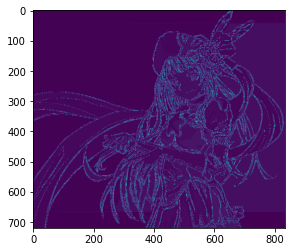

In [95]:
b = image_flood_fill(labels)
print(b)
plt.imshow(b)